In [1]:
import pandas as pd
import numpy as np
import warnings
from pandas import read_csv
import seaborn as sns
import matplotlib.pyplot as plt
#from rest_framework.views import APIView
#from rest_framework.response import Response
#from rest_framework import status
import statsmodels as sm  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from datetime import datetime as dat, timedelta
from pandas import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [4]:
def timeseries_conversion(path,datecol,targcol):
    df = pd.read_csv(path)
    df1 = df[[datecol,targcol]]
    df1.dropna(how='all',inplace = True)
    df1[datecol] = pd.to_datetime(df1[datecol])
    df1[targcol] = df1[targcol].astype(float)
    df1 = df1.sort_values(by=datecol)
    weeknum = df1[datecol].dt.dayofweek
    df1.set_index(datecol,inplace = True)
    return df1,weeknum
path='/home/rupeshr/Desktop/TSA_Python/dataset/time series dataset/Electric_Production.csv'
datecol='DATE'
targcol='IPG2211A2N'
df1,weeknum=timeseries_conversion(path,datecol,targcol)

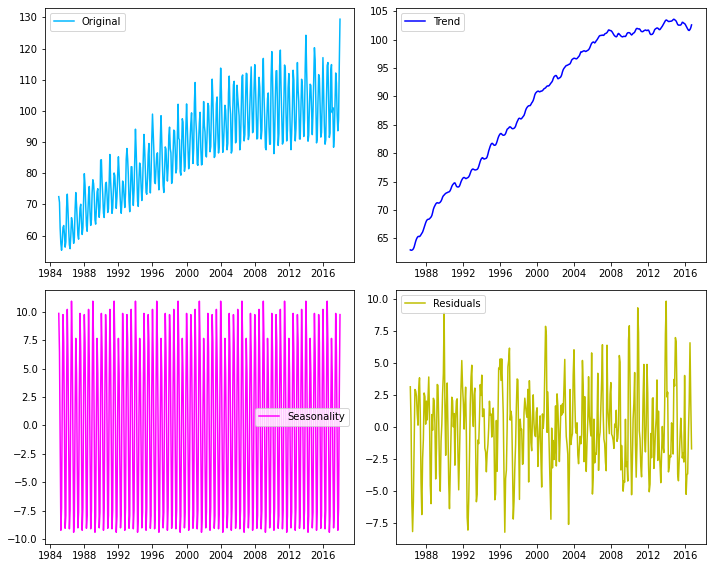

In [5]:
import statsmodels.api as sm  
def seasonal_decompose(df1):
    decomposition = sm.tsa.seasonal_decompose(df1,period=30)
    #print(decomposition)
    #decomposition.plot()
    plt.figure(figsize=(10, 8))
    trend = decomposition.trend
    #print(trend.head(20))
    seasonal = decomposition.seasonal
    #print(seasonal.head(20))
    residual = decomposition.resid
    #print(residual.head(20))

    plt.subplot(221)
    plt.plot(df1, color='#00b8ff', label='Original')
    plt.legend(loc='best')
    plt.subplot(222)
    plt.plot(trend, 'b', label='Trend')
    plt.legend(loc='best')

    plt.subplot(223)
    plt.plot(seasonal, color='#ff00ff', label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(224)
    plt.plot(residual, 'y', label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return

seasonal_decompose(df1)

            Passengers
Month                 
1949-03-31  120.666667
1949-06-30  128.333333
1949-09-30  144.000000
1949-12-31  113.666667
1950-03-31  127.333333


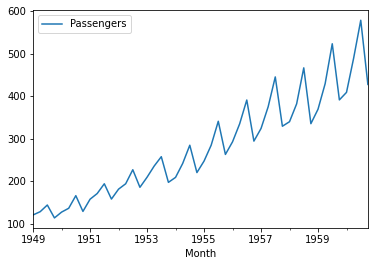

In [4]:
def resamplingtechnique(df1,weeknum,resamplemethod,resampletype,frequencytype,imputation):
    weekday1= weeknum[len(weeknum)-1]
    def weekdays(weekday1):
        if weekday1 == 0:
            day = 'W-MON'
        elif weekday1 == 1:
            day = 'W-TUE'
        elif weekday1 == 2:
            day = 'W-WED'
        elif weekday1 == 3:
            day = 'W-THU'
        elif weekday1 == 4:
            day = 'W-FRI'
        elif weekday1 == 5:
            day = 'W-SAT'
        elif weekday1 == 6:
            day = 'W-SUN'
        return day
    #valueddata = adfuller_test(df1)
    if resamplemethod == 'no':
        pass
    elif resamplemethod =='upsample':
        if resampletype =='no':
            pass
        elif resampletype =='linear':
            hourly = df1.resample('H').interpolate(method='linear') # two columns( one date column and one target column) as the base data frame.
            daily = df1.resample('D').interpolate(method='linear')
            weekly = df1.resample(weekdays(weekday1)).interpolate(method='linear')
            monthly = df1.resample('M').interpolate(method='linear')
            quarterly = df1.resample('Q').interpolate(method='linear')
            yearly =df1.resample('Y').interpolate(method='linear')

        elif resampletype == 'spline':
            hourly = df1.resample('H').interpolate(method='spline',order=2)  # two columns( one date column and one target column) as the base data frame.
            daily = df1.resample('D').interpolate(method='spline', order=2)
            weekly = df1.resample('W-WED').interpolate(method='spline', order=2)
            monthly = df1.resample('M').interpolate(method='spline', order=2)
            quarterly = df1.resample('Q').interpolate(method='spline', order=2)
            yearly = df1.resample('Y').interpolate(method='spline', order=2)


    elif resamplemethod == 'downsample':
        if resampletype == 'no':
            pass
        elif resampletype == 'mean':
            hourly = df1.resample('H').mean()  # two columns( one date column and one target column) as the base data frame.
            daily = df1.resample('D').mean()
            weekly = df1.resample(weekdays(weekday1)).mean()
            monthly = df1.resample('M').mean()
            quarterly = df1.resample('Q').mean()
            yearly = df1.resample('Y').mean()

        elif resampletype == 'sum':
            hourly = df1.resample('H').sum()  # two columns( one date column and one target column) as the base data frame.
            daily = df1.resample('D').sum()
            weekly = df1.resample(weekdays(weekday1)).sum()
            monthly = df1.resample('M').sum()
            quarterly = df1.resample('Q').sum()
            yearly = df1.resample('Y').sum()

    if frequencytype == 'hourly':
        if resampletype == 'no':
            pass
        else:
            df2 = hourly
    elif frequencytype == 'daily':
        if resampletype == 'no':
            pass
        else:
            df2 = daily
    elif frequencytype == 'weekly':
        if resampletype == 'no':
            pass
        else:
            df2 = weekly
    elif frequencytype == 'monthly':
        if resampletype == 'no':
            pass
        else:
            df2 = monthly
    elif frequencytype == 'quarterly':
        if resampletype == 'no':
            pass
        else:
            df2 = quarterly
    elif frequencytype == 'yearly':
        if resampletype == 'no':
            pass
        else:
            df2 = yearly

    if imputation == 'no':
        df3 = df1
    elif imputation == 'mean':
        df3 = df2.fillna(df2.mean())
    elif imputation == 'median':
        df3 = df2.fillna(df2.median())
        
    return df3

resamplemethod ='downsample'
resampletype='mean'
frequencytype='quarterly'
imputation='mean'
df3=resamplingtechnique(df1,weeknum,resamplemethod,resampletype,frequencytype,imputation)
print(df3.head())
df3.plot()

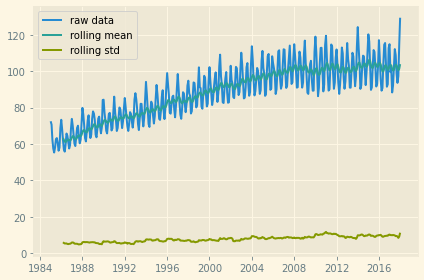

In [10]:
import matplotlib.dates as mdates
plt.style.use('Solarize_Light2')
def check_stationary(df3,check_stationary_type,differencing):
    if check_stationary_type =='Rolling_statistics':
        if differencing =='No':
            plt.plot(df3.index, df3, label='raw data')
            plt.plot(df3.rolling(window=15).mean(), label="rolling mean");
            plt.plot(df3.rolling(window=15).std(), label="rolling std");
            plt.legend()
            plt.tight_layout()
            #fig.autofmt_xdate()
        elif differencing =='Basic':
            #df4=pd.DataFrame=()
            df4 = (df3 - df3.rolling(window=12).mean()) / df3.rolling(window=12).std()
            plt.plot(df4.index, df4, label="de-trended data")
            plt.plot(df4.rolling(window=12).mean(), label="rolling mean");
            plt.plot(df4.rolling(window=12).std(), label="rolling std");
            plt.legend()
            plt.tight_layout()
            #fig.autofmt_xdate()
        elif differencing =='Advanced':
            #df4=pd.DataFrame()
            df4= (df3 - df3.rolling(window=12).mean()) / df3.rolling(window=12).std()
            df4= df4 - df4.shift(12)
            plt.plot(df4.index, df4, label="12 lag differenced de-trended data")
            plt.plot(df4.rolling(window=12).mean(), label="rolling mean");
            plt.plot(df4.rolling(window=12).std(), label="rolling std");
            plt.legend()
            plt.tight_layout()
            #fig.autofmt_xdate()
    elif check_stationary_type =='ADFTest':
        if differencing =='No':
            print(" > Is the data stationary ?")
            dftest = adfuller(df3, autolag='AIC')
            print("Test statistic = {:.3f}".format(dftest[0]))
            print("P-value = {:.3f}".format(dftest[1]))
            print("Critical values :")
            for k, v in dftest[4].items():
                print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
            return df3
    
        elif differencing =='Basic':
            df4=df3-df3.shift(1)
            print("\n > Is the de-trended data stationary ?")
            dftest = adfuller(df4.dropna(), autolag='AIC')
            print("Test statistic = {:.3f}".format(dftest[0]))
            print("P-value = {:.3f}".format(dftest[1]))
            print("Critical values :")
            for k, v in dftest[4].items():
                print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
            #df4=pd.DataFrame(df4.dropna())
            return df4
        elif differencing =='Advanced':
            df4=df3-df3.shift(1)
            df4 = df4 - df4.shift(12)
            print("\n > Is the 12-lag differenced de-trended data stationary ?")
            dftest = adfuller(df4.dropna(), autolag='AIC')
            print("Test statistic = {:.3f}".format(dftest[0]))
            print("P-value = {:.3f}".format(dftest[1]))
            print("Critical values :")
            for k, v in dftest[4].items():
                print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
            #df4=pd.DataFrame(df4.dropna())
            return df4
        

check_stationary_type='Rolling_statistics'
differencing='No'
df4=check_stationary(df1,check_stationary_type,differencing)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


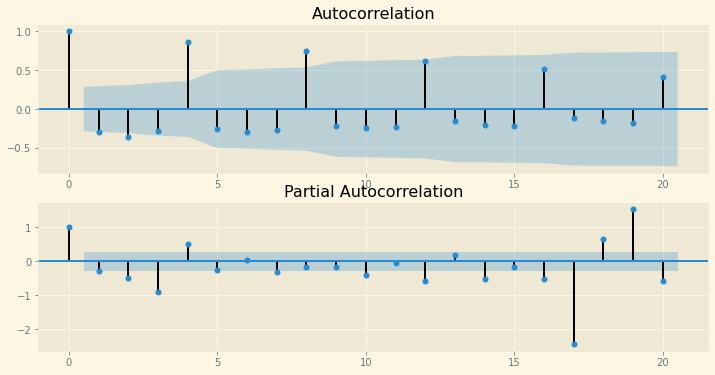

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def acf_pacf_plot(df4):
    df4=df4.dropna()
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df4, ax=ax[0], lags=20)
    ax[1] = plot_pacf(df4, ax=ax[1], lags=20)
    return
acf_pacf_plot(df4)

In [15]:
def timeseries_models(df3,algorithmn,ratio):
    cols = df3.columns
    train_size = int(len(df3) * ratio)
    train, test = df3[0:train_size], df3[train_size:len(df3)]

    if frequencytype =='minute':
        value=525960
    elif frequencytype =='hourly':
        value =8766
    elif frequencytype == 'daily':
        value = 7
    elif frequencytype == 'weekly':
        value = 52
    elif frequencytype == 'monthly':
        value = 12
    elif frequencytype == 'quarterly':
        value = 4
    elif frequencytype == 'yearly':
        value=1
    #algorithm = input('Enter algorithm to use:')
    if algorithm == 'SimpleExponentialSmoothing':
        model= SimpleExpSmoothing(train)
        model_fit = model.fit(smoothing_level=.5)
        prediction=pd.DataFrame(model_fit.forecast(steps=len(test)),columns=df3.columns)
        future_forecast=model_fit.forecast(steps=future_period)
        future_forecast=future_forecast.values

    elif algorithm == 'Holtlinear':
        model=Holt(train)
        model_fit=model.fit()
        prediction=pd.DataFrame(model_fit.forecast(steps=len(test)),columns=df3.columns)
        future_forecast=model_fit.forecast(steps=future_period)
        future_forecast = future_forecast.values

    elif algorithm =='Holtwinter':
        trend = input('trend as "add" or "mul":')#When the trend increases or decreases linearly, additive equation is used whereas when the trend increases of decreases exponentially, multiplicative equation is used
        seasonal = input('seasonal as "add" or "mul":')#The additive method is preferred when the seasonal variations are roughly constant through the series,while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series.
        model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal,seasonal_periods=value)
        model_fit = model.fit()
        prediction = pd.DataFrame(model_fit.forecast(steps=len(test)),columns=df3.columns)
        future_forecast=model_fit.forecast(steps=future_period)
        future_forecast = future_forecast.values

    elif algorithm =='ARIMA':
        model = auto_arima(train, start_p=0, d=1, start_q=0, max_p=3, max_d=2, max_q=3,
                           seasonal=False, error_action='warn', trace=True, supress_warning=True,
                           stepwise=True, random_state=20, n_fits=50)
        model.fit(train)
        prediction=pd.DataFrame(model.predict(n_periods=len(test)),index=test.index,columns=test.columns)
        future_forecast=model.predict(n_periods=future_period)
    elif algorithm == 'SARIMA':
        model = auto_arima(train, start_p=0, d=0, start_q=0, max_p=2, max_d=1, max_q=2,
                           start_P=0, D=0, start_Q=0, max_P=2, max_D=1, max_Q=2, m=value,
                           seasonal=True, error_action='warn', trace=True, supress_warning=True,
                           stepwise=True, random_state=20, n_fits=50)
        model.fit(train)
        prediction=pd.DataFrame(model.predict(n_periods=len(test)),index=test.index,columns=test.columns)
        future_forecast=model.predict(n_periods=future_period)

    for i in cols:
        print('MAE value for', i, 'is : ', mean_absolute_error(prediction, test))
        print('RMSE value for', i, 'is : ', sqrt(mean_squared_error(prediction, test)))
        print('MAPE value for', i, 'is : ',np.mean(np.abs((test.values - prediction.values) / test.values)) * 100)
        
    return train,test,prediction,future_forecast
        
        
algorithm ='ARIMA'
ratio=0.80
future_period=12
train,test,prediction,future_forecast=timeseries_models(df3,algorithm,ratio)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=388.748, BIC=391.970, Time=0.007 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=386.934, BIC=391.766, Time=0.024 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=368.262, BIC=373.095, Time=0.049 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=387.697, BIC=389.308, Time=0.005 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=379.589, BIC=386.032, Time=0.154 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=315.135, BIC=323.190, Time=0.213 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=302.207, BIC=311.873, Time=0.189 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=365.242, BIC=373.296, Time=0.110 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=298.083, BIC=309.359, Time=0.193 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=376.839, BIC=386.505, Time=0.155 seconds
Near non-invertible roots for order (2, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA(3,1,3)x(0,0,0,0) [intercept=True]; AIC=299.670, BIC=312.557, Time=0.205 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=352.453, BIC=363.729, Time=0.273 seconds
Total fit time: 1.584 seconds


TypeError: 'tuple' object is not callable

In [14]:
def futureforecast(test,future_forecast,future_period):
    predict_period = future_period
    if frequencytype == 'minute':
        future_dates = pd.date_range(start=str(test.index[-1]), periods=predict_period, freq='T')
    elif frequencytype == 'hourly':
        future_dates = pd.date_range(start=str(test.index[-1]), periods=predict_period, freq='H')
    elif frequencytype == 'daily':
        future_dates = pd.date_range(start=str(test.index[-1]), periods=predict_period, freq='D')
    elif frequencytype == 'weekly':
        future_dates = pd.date_range(start=str(test.index[-1]), periods=predict_period, freq=weekdays(weekday1))
    elif frequencytype == 'monthly':
        future_dates = pd.date_range(start=str(test.index[-1]), periods=predict_period, freq='M')
    elif frequencytype == 'quarterly':
        future_dates = pd.date_range(start=str(test.index[-1]), periods=predict_period, freq='Q')
    elif frequencytype == 'yearly':
        future_dates = pd.date_range(start=str(test.index[-1]), periods=predict_period, freq='Y')

    final_df = pd.DataFrame()
    final_df[datecol] = future_dates
    final_df.set_index(datecol,inplace=True)
    final_df[targcol] = future_forecast.astype(int)
    return final_df
    
future_period= 12
final_df=futureforecast(test,future_forecast,future_period)

NameError: name 'test' is not defined

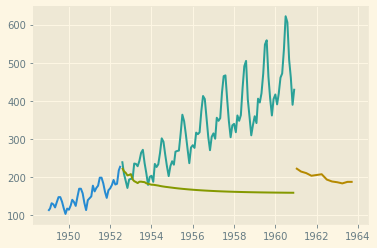

In [56]:
plt.plot(train, label='Train')
plt.plot(test, label='test')
plt.plot(prediction, label='Prediction')
plt.plot(final_df, label='future')
plt.show()